# **Agents Estimation and AQI prediction**


## **Notebook Setup**

In [40]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [42]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [43]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [44]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [45]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train
merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128614, 24), (128614, 1)
Agent O3 train set shape: 	(85826, 24), (85826, 1)
Agent PM10 train set shape: 	(5283, 33), (5283, 1)
Agent PM2.5 train set shape: 	(3519, 33), (3519, 1)
Agent C6H6 train set shape: 	(40778, 24), (40778, 1)
Agent CO train set shape: 	(43036, 24), (43036, 1)


## **Agents Estimations**

Prepare a dictionary containing all the models to use for each agent of each station.

### **Hourly models**

#### LSTM

In [46]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}


lstm = ('LSTM', build_lstm_model, lstm_params, lstm_train_params, True)

#### 1D Convolution

In [47]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

conv2 = ('Conv1D 2', build_conv_model, conv2_params, conv2_train_params, True)

### **Daily Models**

#### FFNN

In [48]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

FFNN_daily = ('Feed Forward NN BatchNorm', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [49]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
}

rfr = ('Random Forest Regressor 2', RandomForestRegressor, rfr_params, None, False)

### **Training**

In [50]:
models = {
    'NO2': lstm, 
    'O3': lstm,
    'PM10': rfr,
    'PM2.5': FFNN_daily,
    'C6H6': conv2, 
    'CO': lstm, 
}

In [51]:
agents_predictions = train_agents_1_per_agent(models, train_sets, merged_train_sets, test_sets)

Predicting NO2 using LSTM...
Predicting O3 using LSTM...
Predicting PM10 using Random Forest Regressor 2...
Predicting PM2.5 using Feed Forward NN BatchNorm...
Predicting C6H6 using Conv1D 2...
Predicting CO using LSTM...


In [52]:
metrics_predictions = training_results_to_dataframe(agents_predictions, multiple_models=False)
metrics_predictions

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,NO2,0.662724,0.376925,0.483671,0.439203
1,GIARDINI MARGHERITA,O3,0.424483,0.797607,0.320173,0.180186
2,GIARDINI MARGHERITA,PM10,0.723681,0.419793,0.513762,0.523714
3,GIARDINI MARGHERITA,PM2.5,0.733666,0.465569,0.496802,0.538266
4,PORTA SAN FELICE,C6H6,0.559259,0.660462,0.350356,0.312771
5,PORTA SAN FELICE,CO,0.767307,0.436927,0.602599,0.588761
6,PORTA SAN FELICE,NO2,1.003023,-0.862221,0.813229,1.006055
7,PORTA SAN FELICE,PM10,0.707337,0.504747,0.483271,0.500326
8,PORTA SAN FELICE,PM2.5,0.642540,0.599246,0.452655,0.412858
9,VIA CHIARINI,NO2,0.562397,0.487223,0.416701,0.316290


## **AQI calculation**

In [53]:
agents_predictions_original_dist = agents_predictions.copy()
test_sets_original_dist = test_sets.copy()

for station in stations:
    for agent in agents_predictions_original_dist[station]:
        test_sets_original_dist[station][agent]['y'] = (test_sets_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_original_dist[station][agent]['predictions'] = (agents_predictions_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']

In [54]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}
pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}
pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [55]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}
true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}
true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

In [56]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## **AQI Comparison**

In [57]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}

### **Hourly AQI**

#### **Visualization**

Station GIARDINI MARGHERITA AQI:


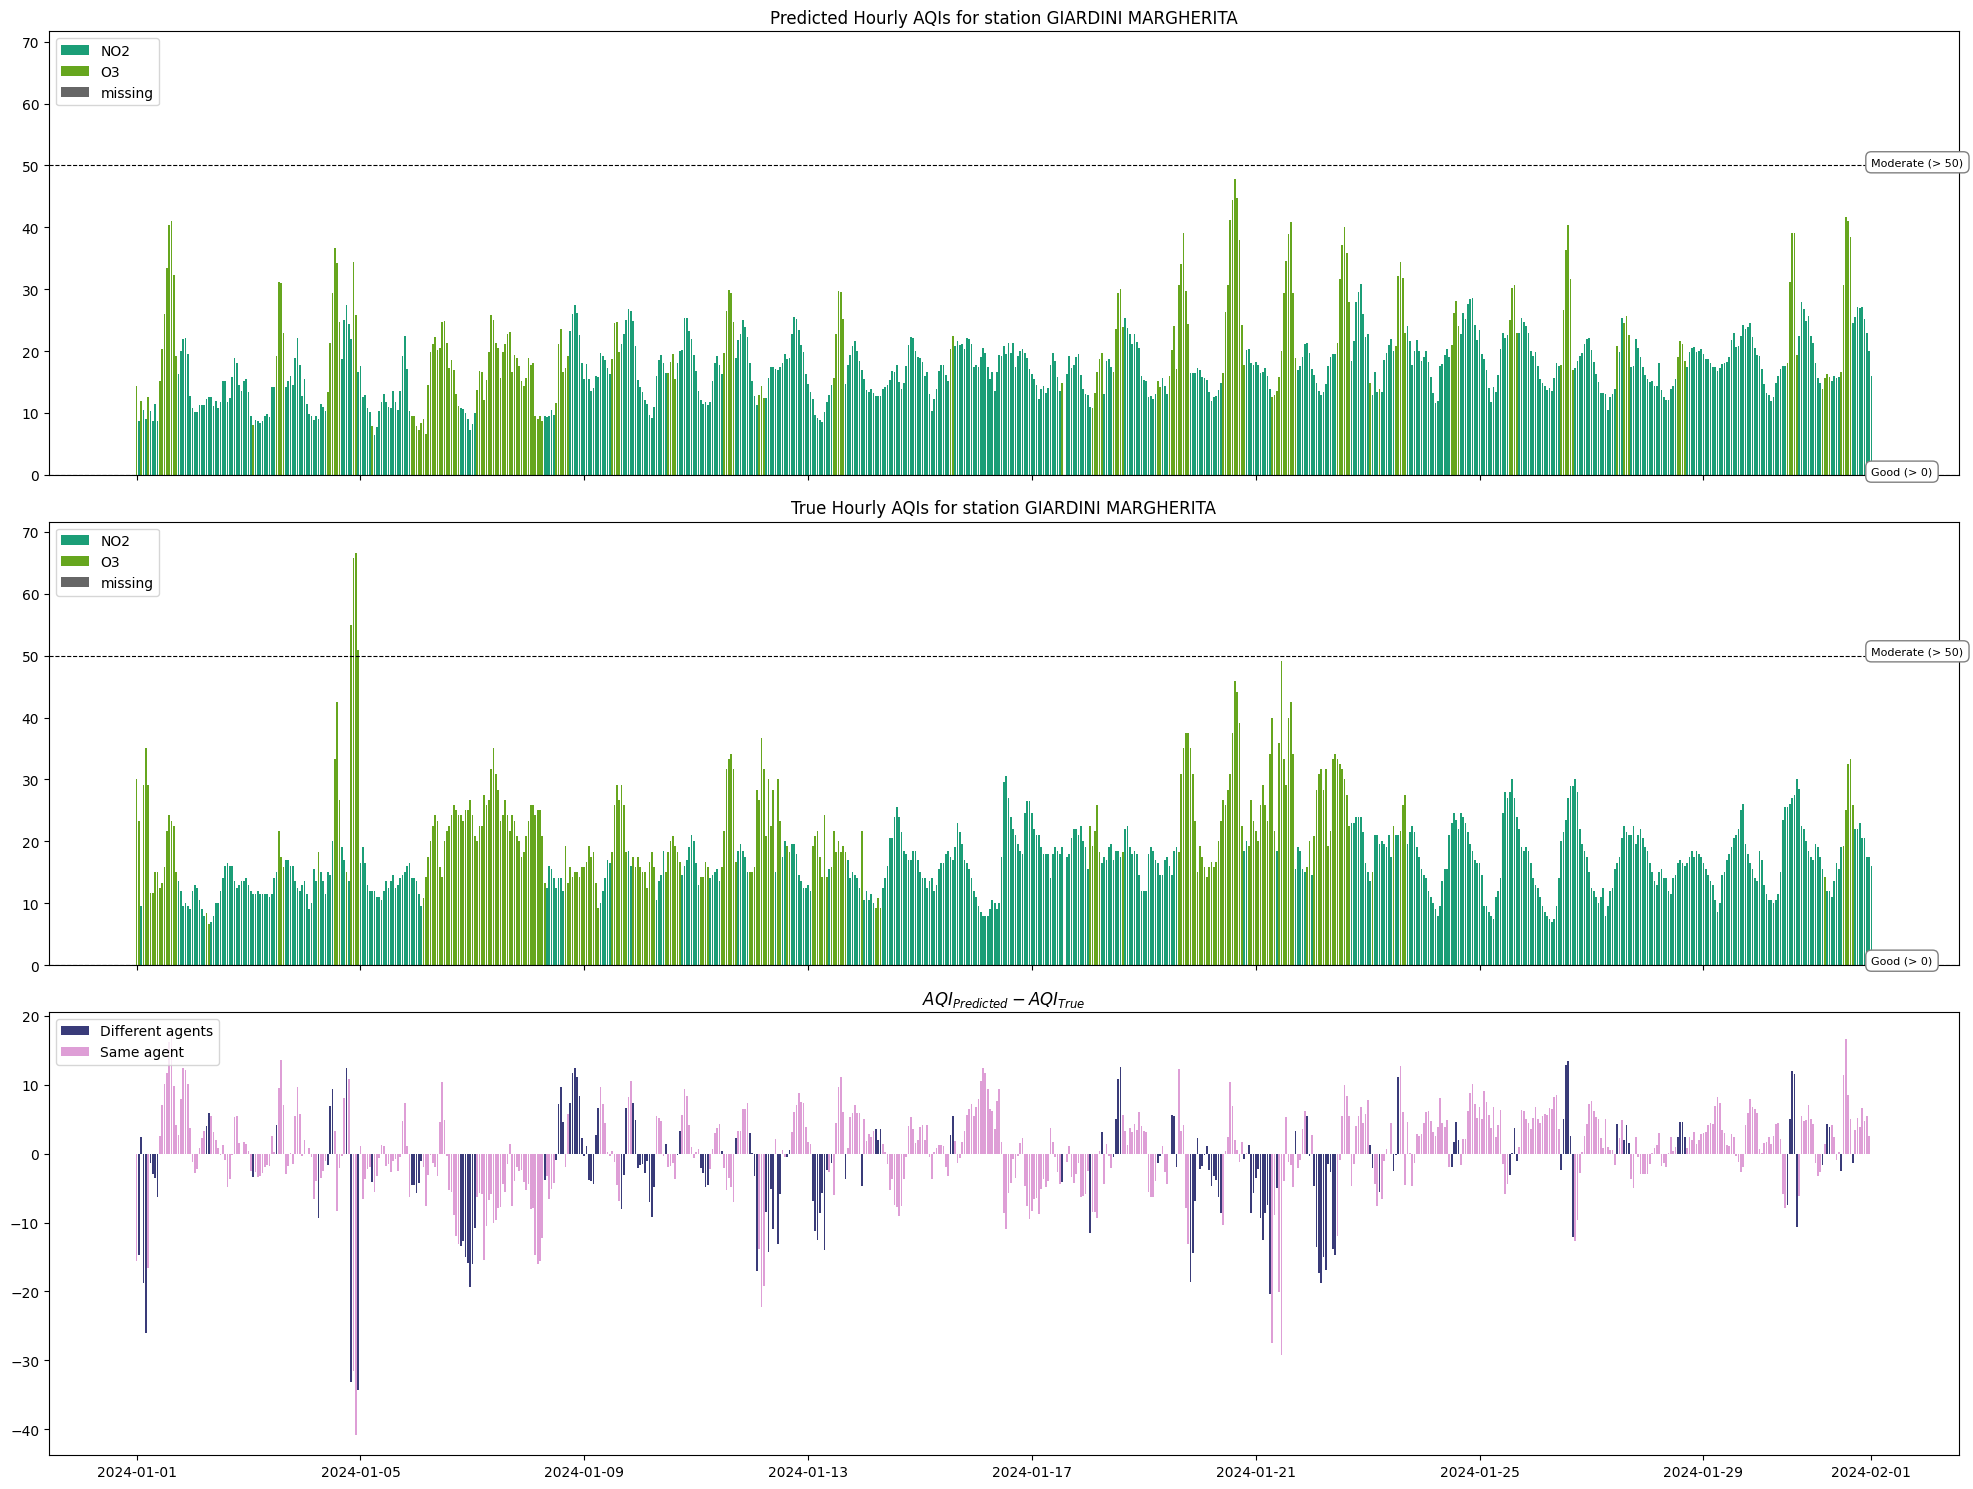

Station PORTA SAN FELICE AQI:


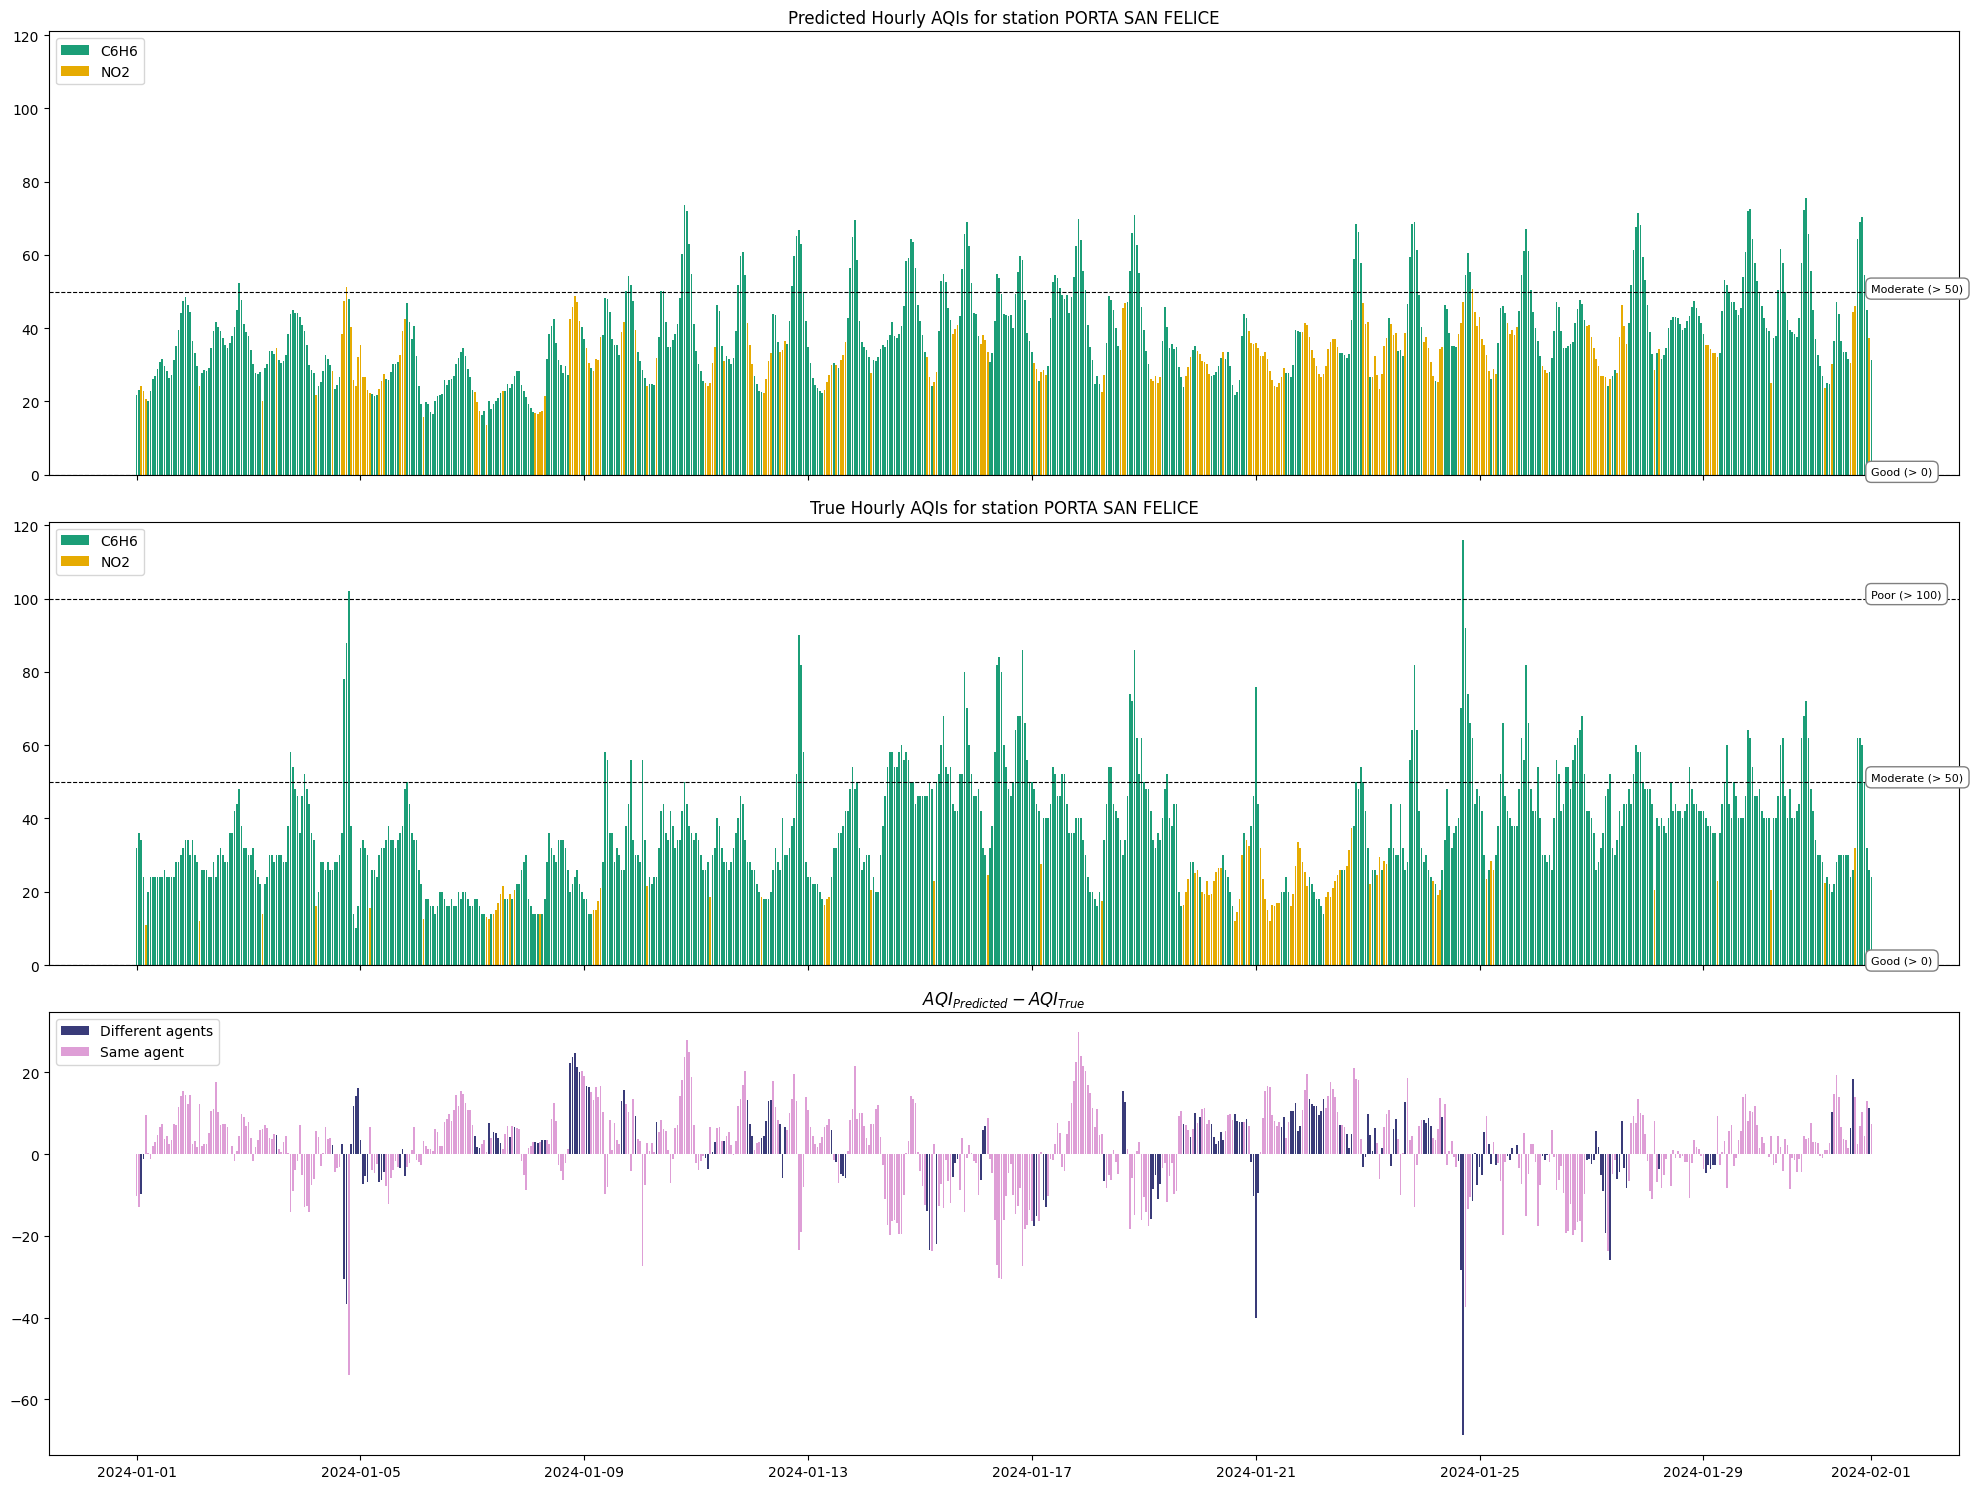

Station VIA CHIARINI AQI:


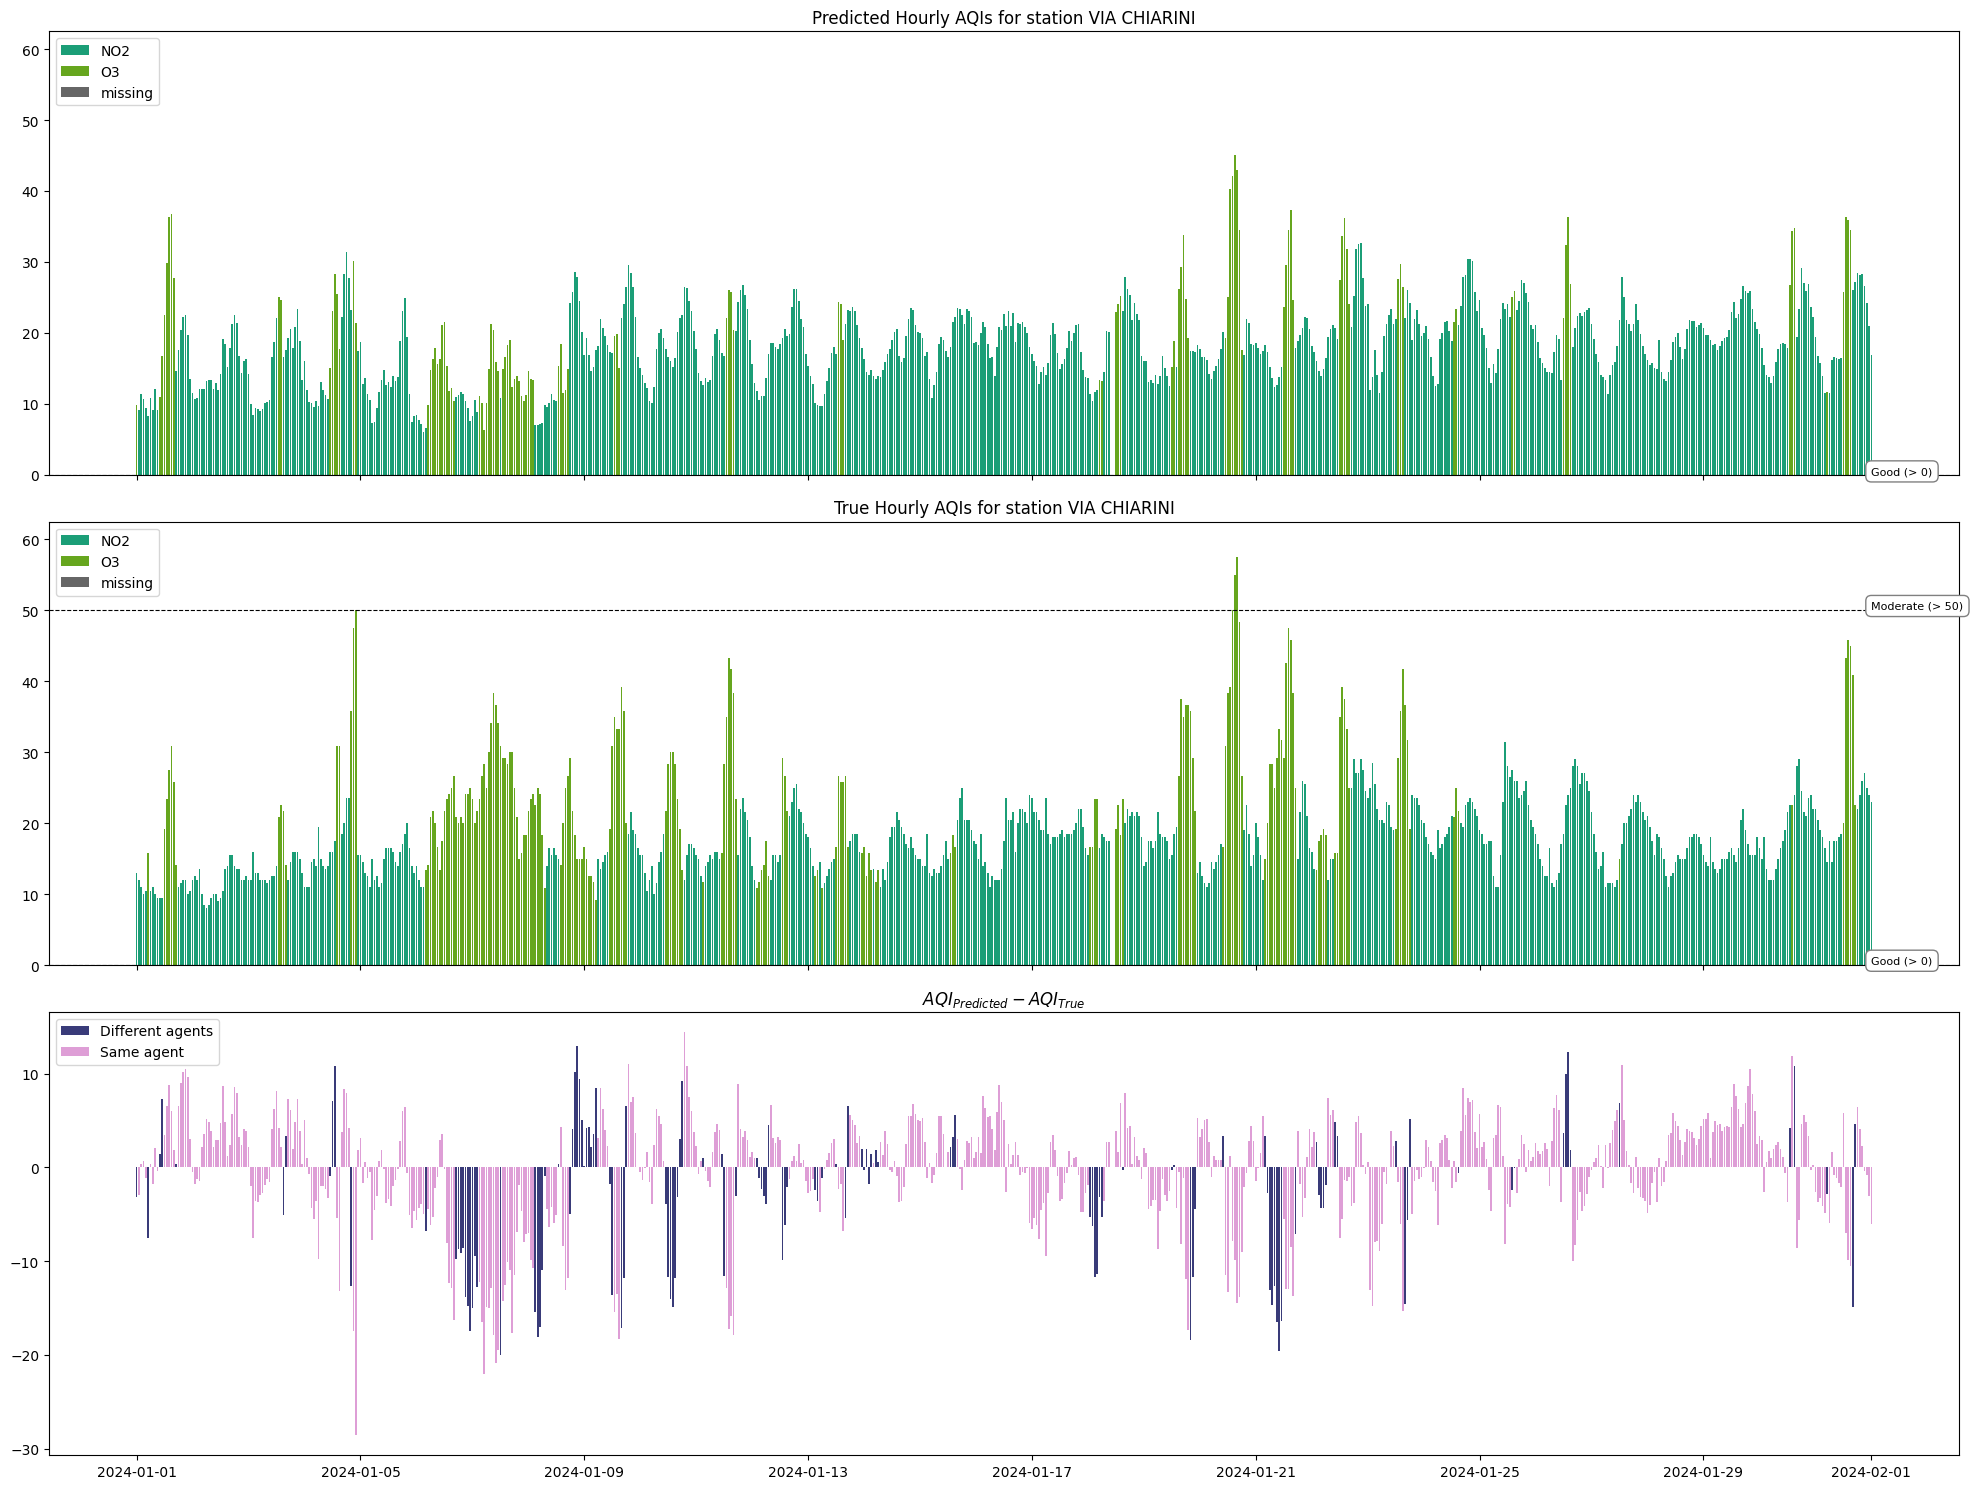

In [58]:
start=datetime(2024,1,1)
end=datetime(2024,2,1)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

#### **Metrics**

Station GIARDINI MARGHERITA


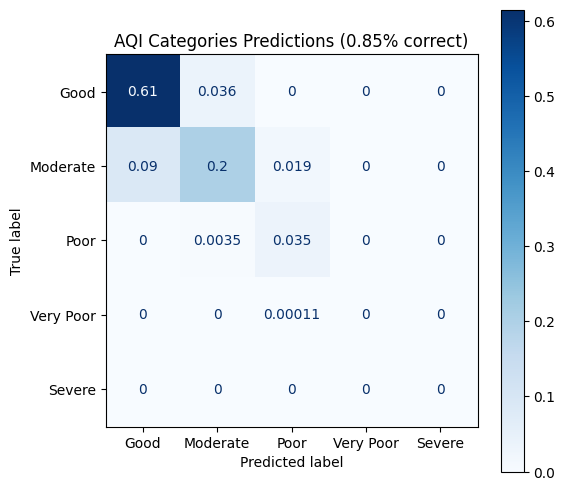

---------------------------------------------
> Absolute Mean AQI Difference: 9.61
> Positive Average AQI Difference: 8.38
> Negative Average AQI Difference: -10.88
> Percentage of Positive Differences: 50.79%
> Percentage of Negative Differences: 48.99%
> Percentage of Agent Values:
   - Same agent: 87.31
   - Different agents: 12.69
Station PORTA SAN FELICE


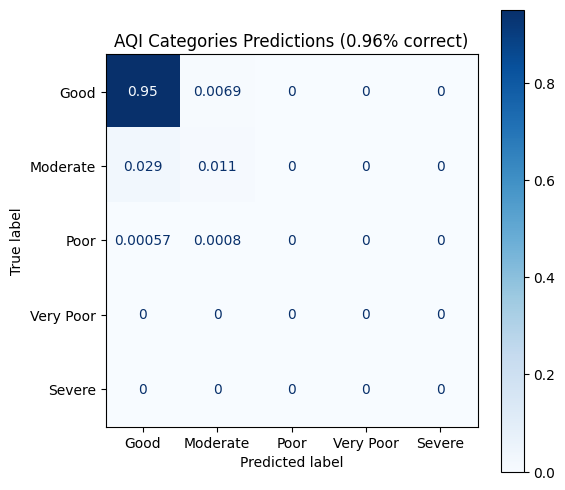

---------------------------------------------
> Absolute Mean AQI Difference: 6.12
> Positive Average AQI Difference: 5.81
> Negative Average AQI Difference: -6.53
> Percentage of Positive Differences: 57.61%
> Percentage of Negative Differences: 42.20%
> Percentage of Agent Values:
   - Same agent: 60.99
   - Different agents: 39.01
Station VIA CHIARINI


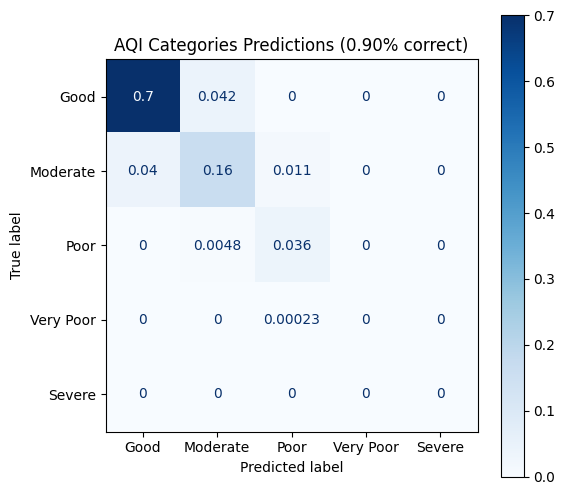

---------------------------------------------
> Absolute Mean AQI Difference: 7.70
> Positive Average AQI Difference: 7.75
> Negative Average AQI Difference: -7.64
> Percentage of Positive Differences: 58.78%
> Percentage of Negative Differences: 40.91%
> Percentage of Agent Values:
   - Same agent: 86.86
   - Different agents: 13.14


In [59]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

### **Daily AQI**

#### **Visualization**

Station GIARDINI MARGHERITA AQI:


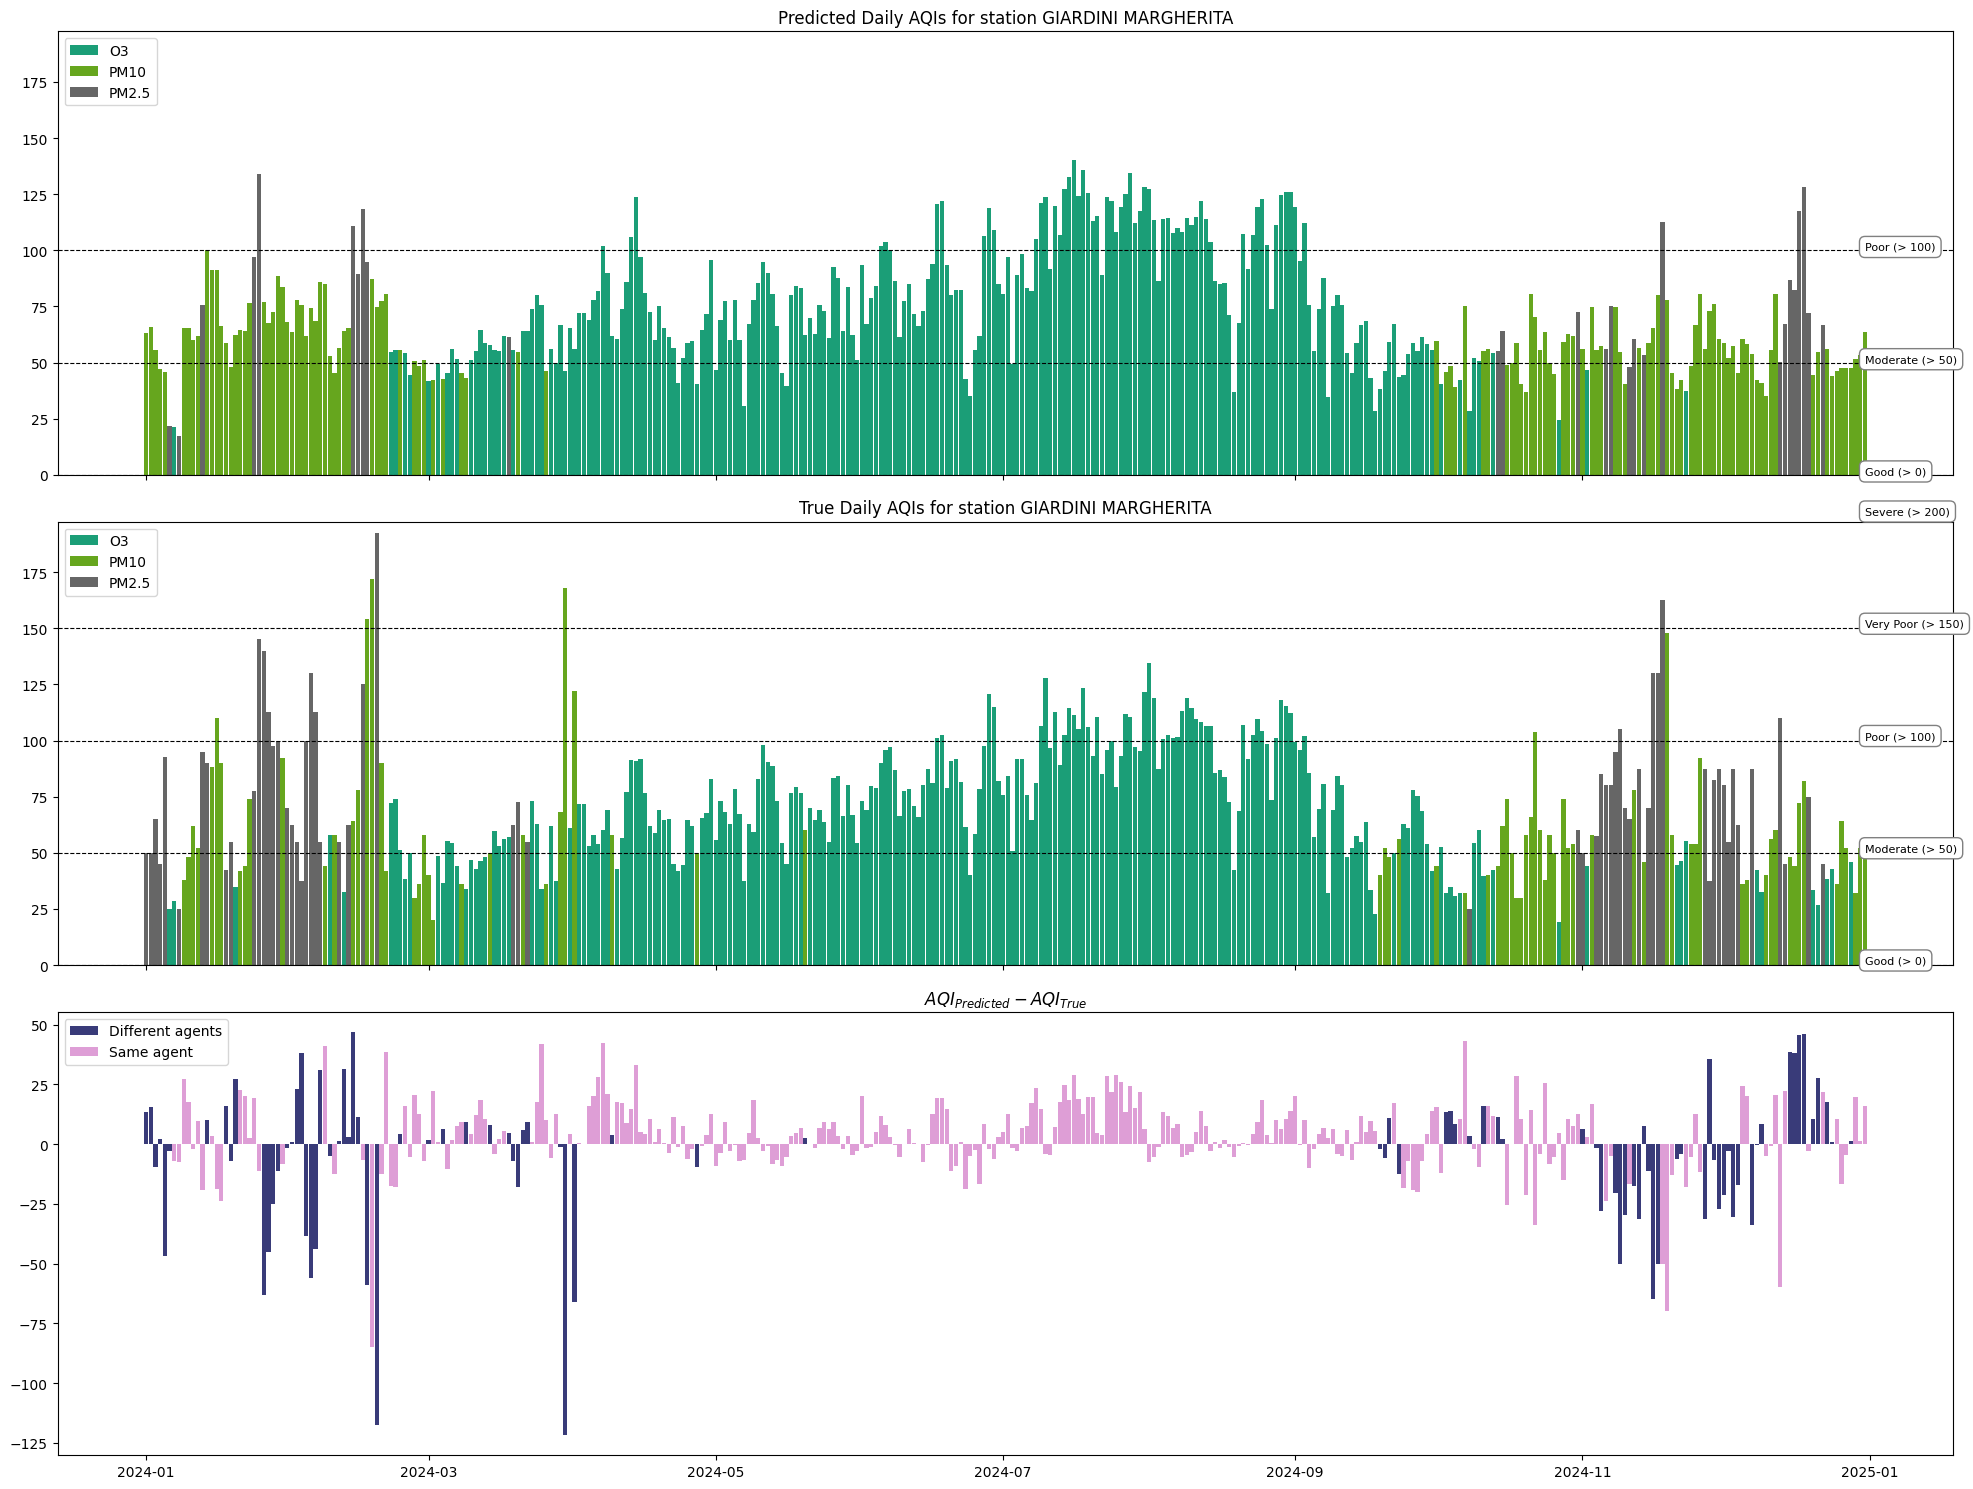

Station PORTA SAN FELICE AQI:


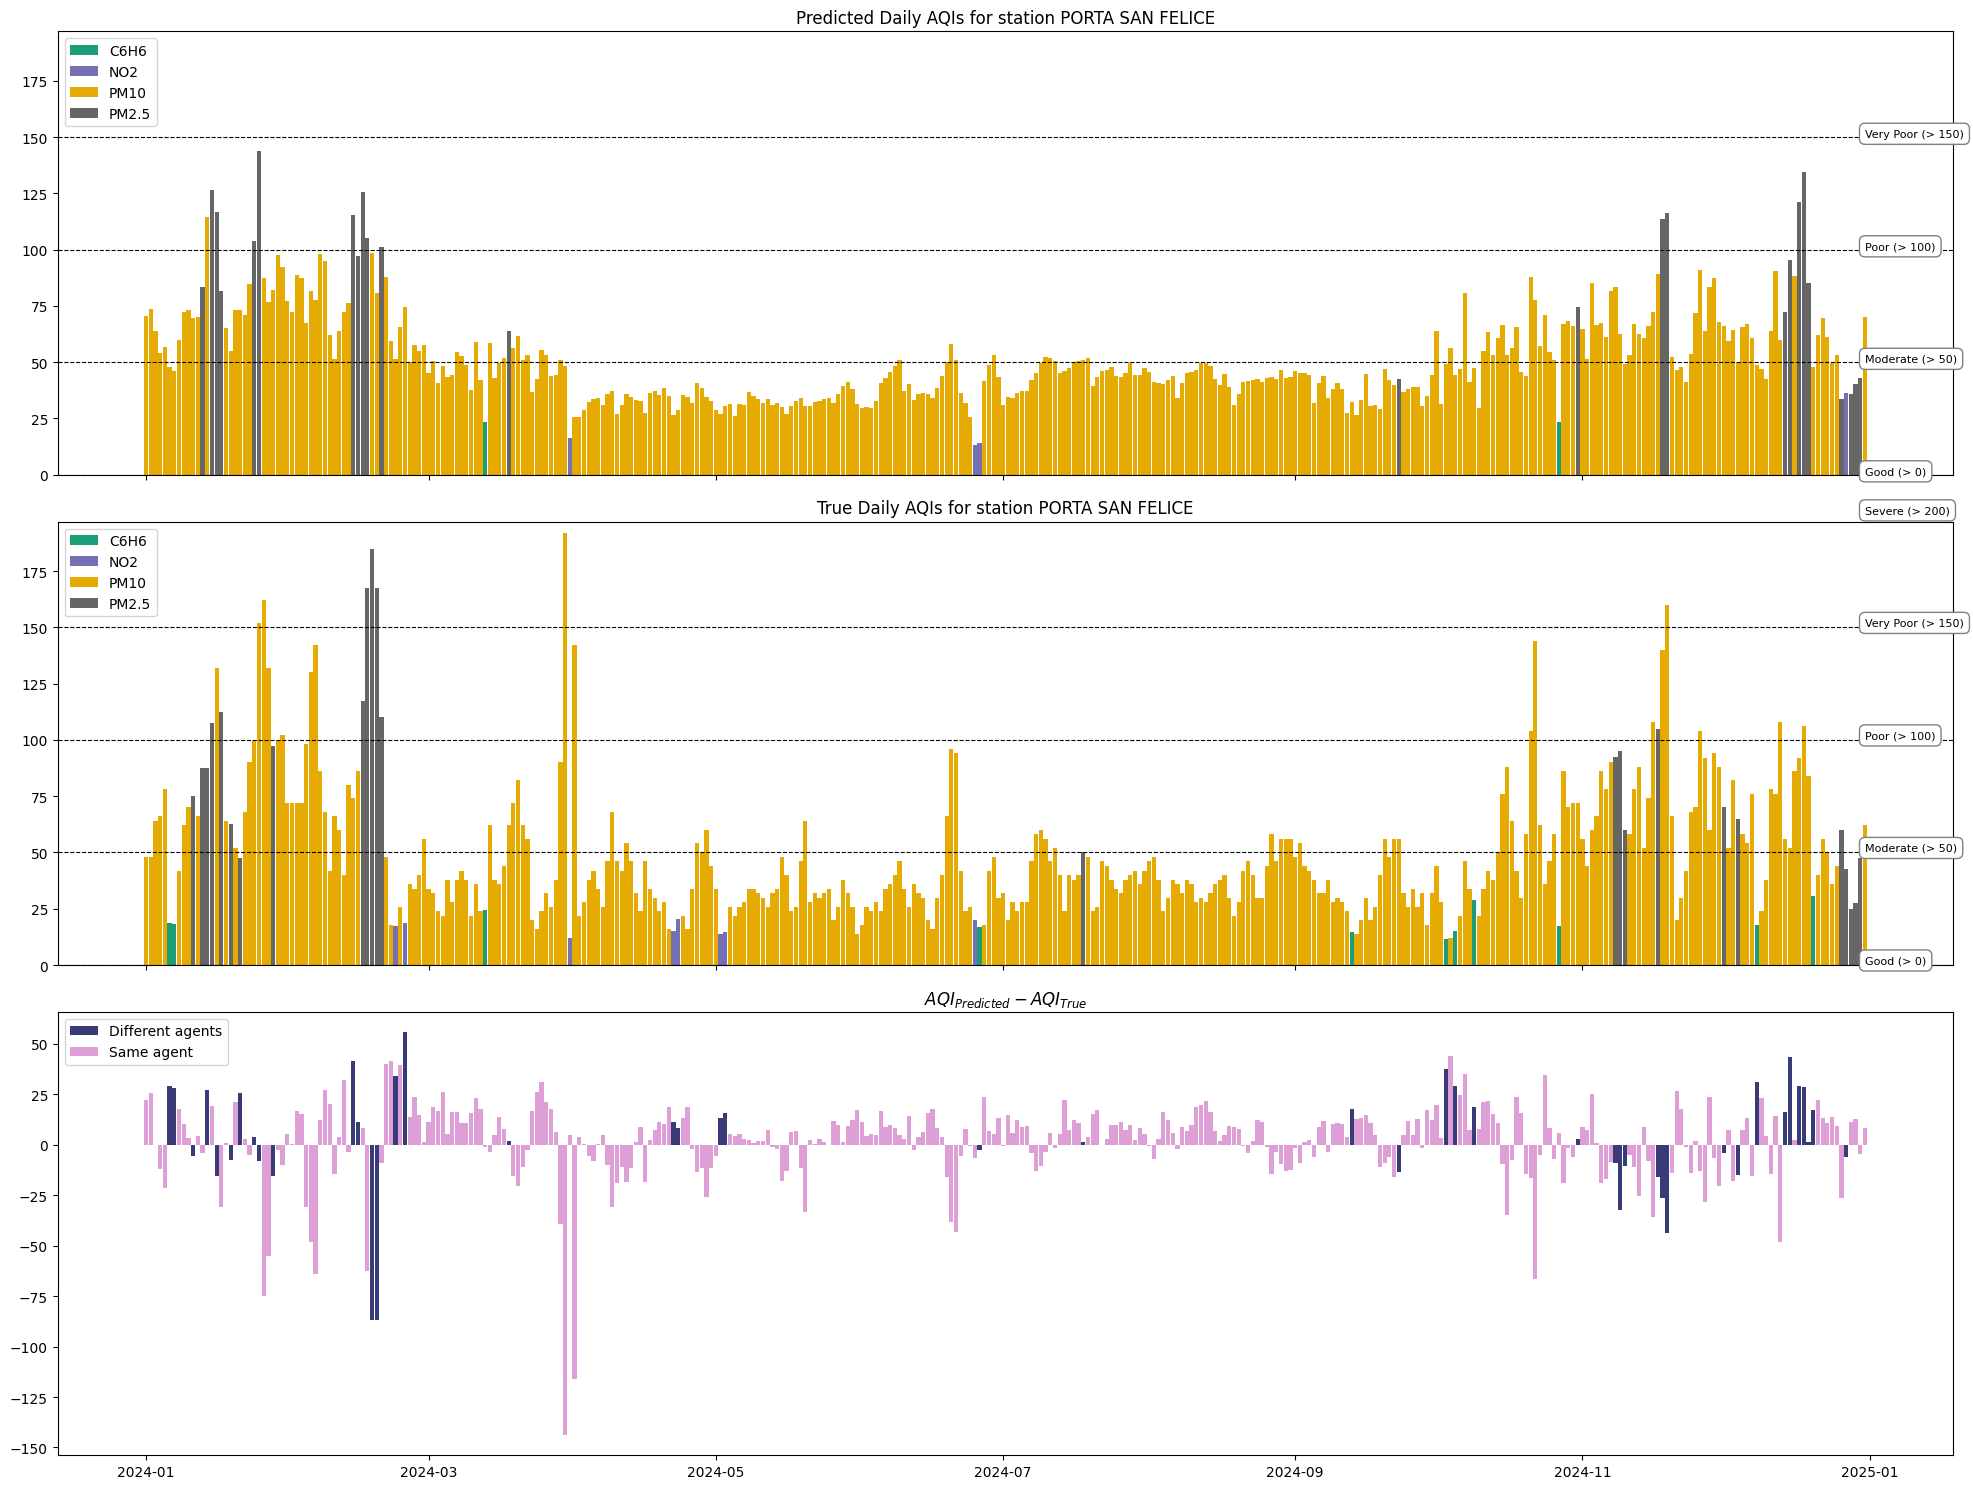

Station VIA CHIARINI AQI:


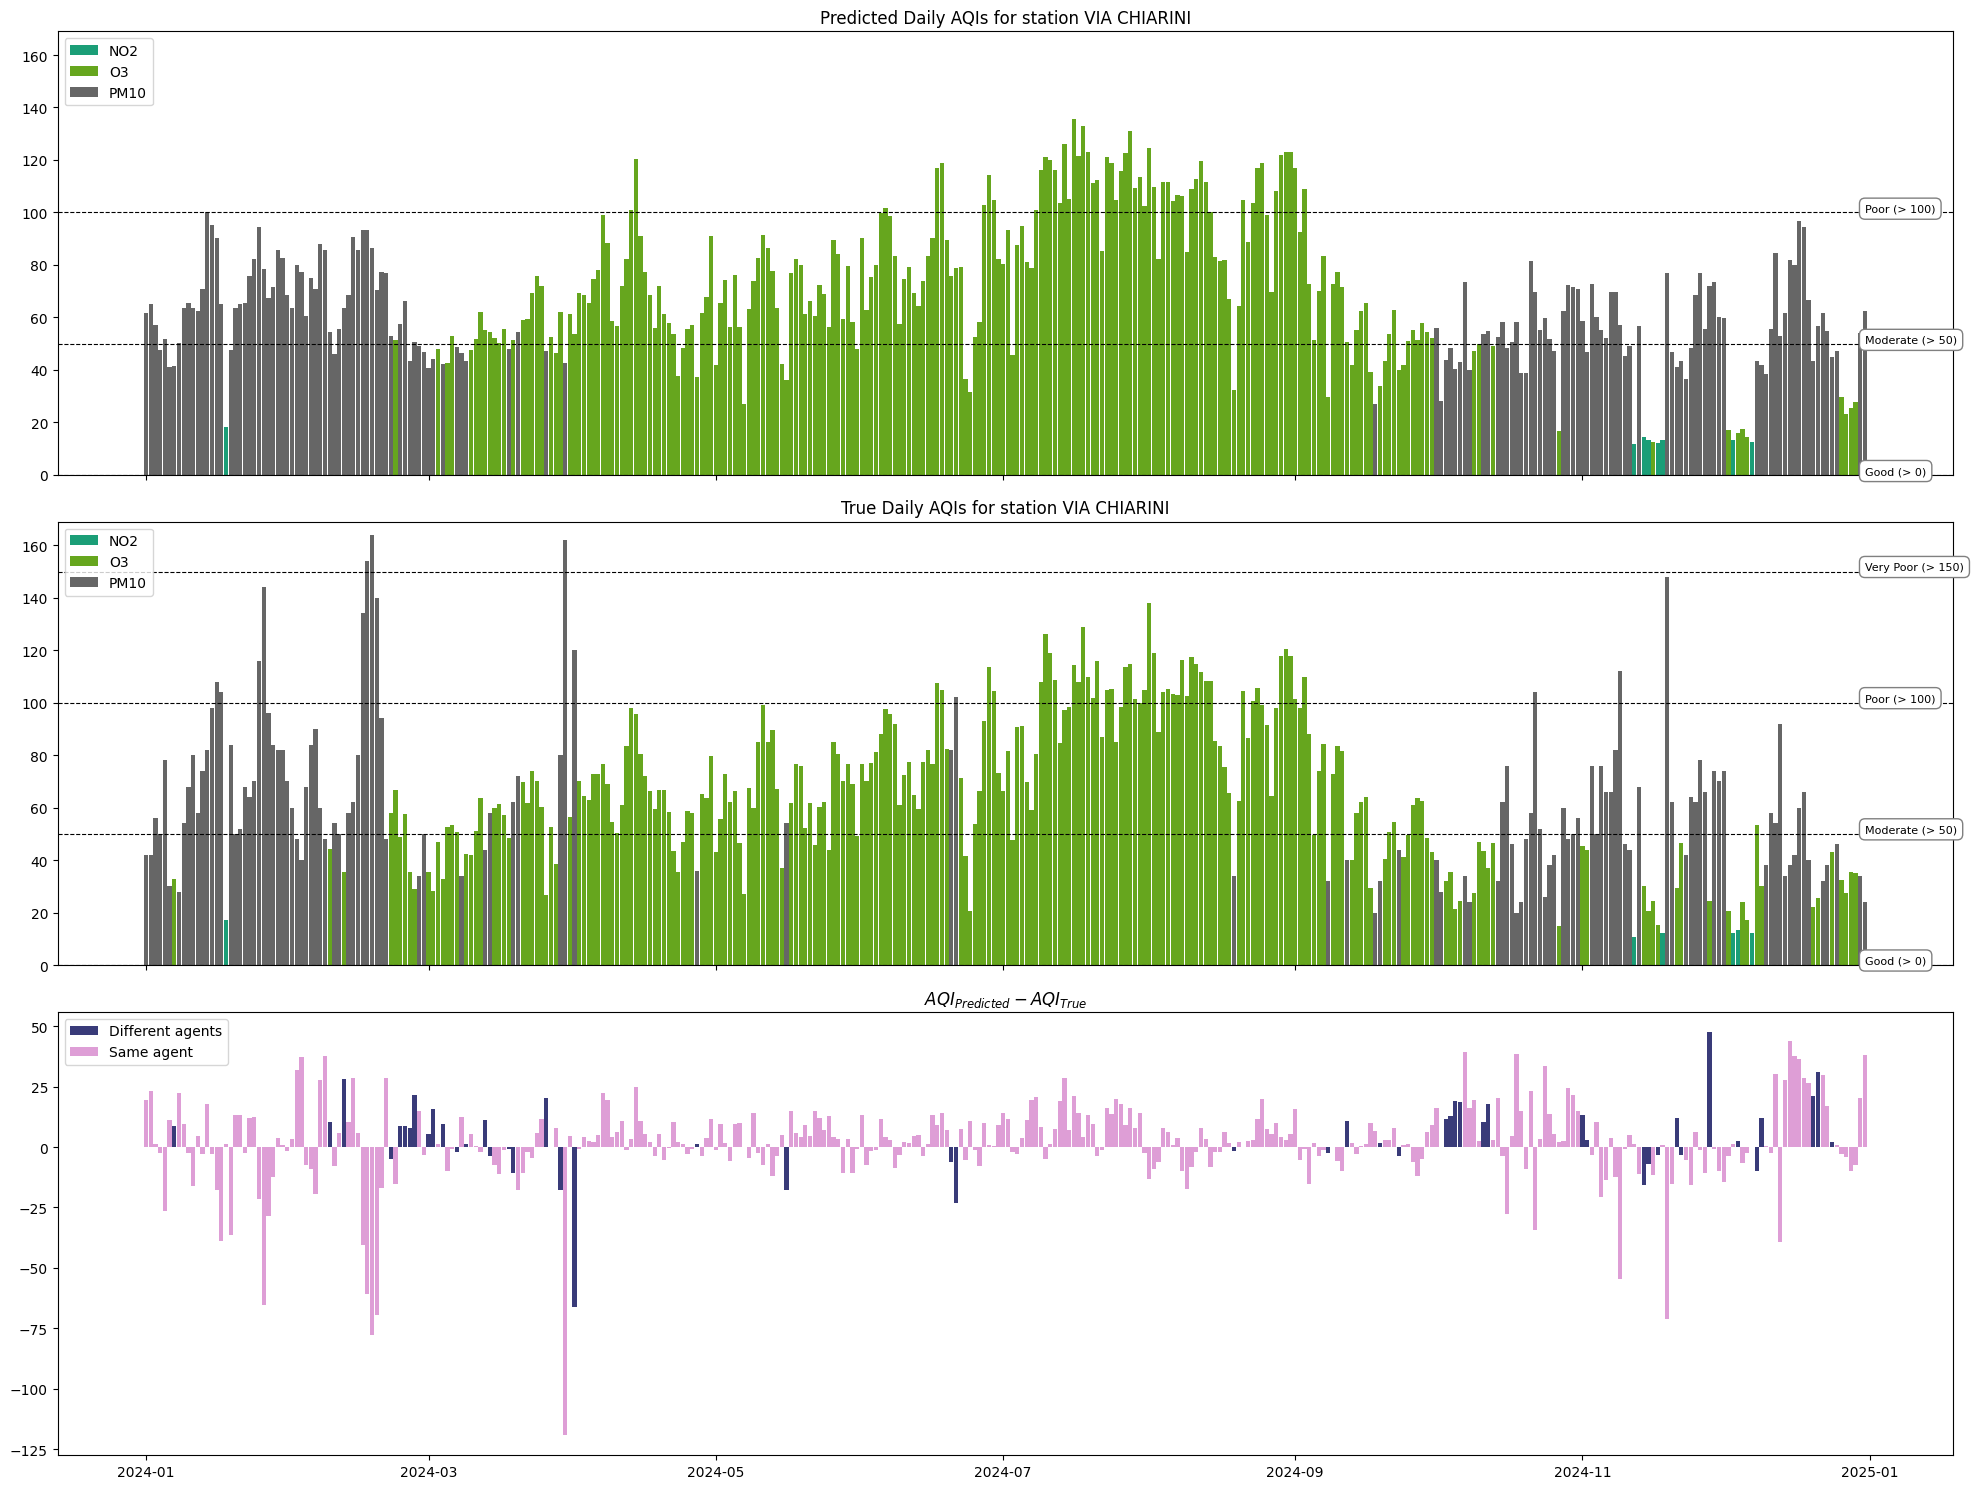

In [60]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=categories,
        figsize=(20, 5), s=start, e=end)

#### **Metrics**

Station GIARDINI MARGHERITA


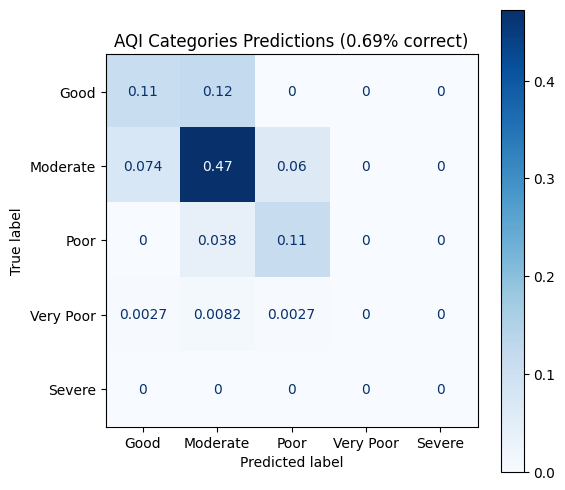

---------------------------------------------
> Absolute Mean AQI Difference: 13.83
> Positive Average AQI Difference: 12.91
> Negative Average AQI Difference: -15.12
> Percentage of Positive Differences: 58.20%
> Percentage of Negative Differences: 41.80%
> Percentage of Agent Values:
   - Same agent: 75.14
   - Different agents: 24.86
Station PORTA SAN FELICE


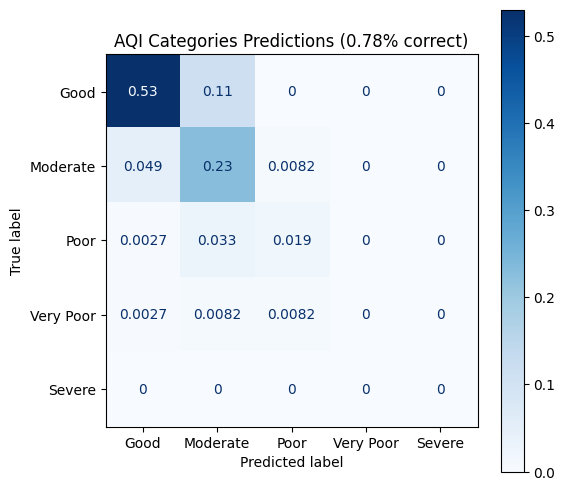

---------------------------------------------
> Absolute Mean AQI Difference: 14.45
> Positive Average AQI Difference: 12.69
> Negative Average AQI Difference: -17.60
> Percentage of Positive Differences: 64.21%
> Percentage of Negative Differences: 35.79%
> Percentage of Agent Values:
   - Same agent: 87.7
   - Different agents: 12.3
Station VIA CHIARINI


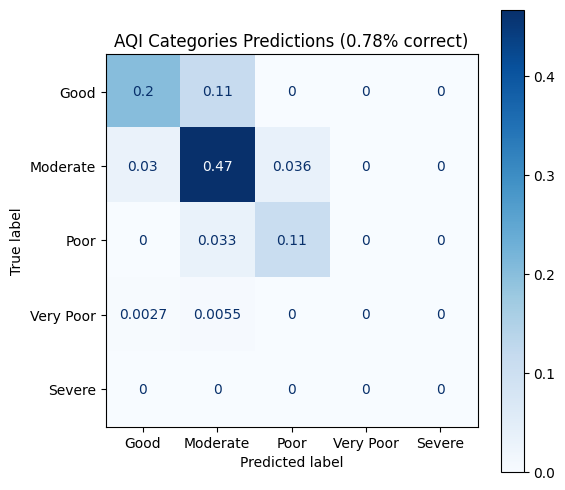

---------------------------------------------
> Absolute Mean AQI Difference: 11.43
> Positive Average AQI Difference: 11.02
> Negative Average AQI Difference: -12.10
> Percentage of Positive Differences: 61.48%
> Percentage of Negative Differences: 38.52%
> Percentage of Agent Values:
   - Same agent: 86.61
   - Different agents: 13.39


In [61]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')

TODO dopo rieseguito il 5.1 -> 6.1